# Loan Approval Classification: End-to-End Machine Learning Workflow


---


## 🧭 Overview


This notebook walks through a **complete machine learning workflow** for predicting whether a loan application will be approved based on applicant and loan characteristics. The process covers:


1. **Exploratory Data Analysis (EDA)** to understand data distributions, detect issues, and identify predictive features.
2. **Data Cleaning & Preprocessing** to handle anomalies, missing values, and categorical variables.
3. **Model Training & Hyperparameter Tuning** using GridSearchCV across multiple classification algorithms.
4. **Model Evaluation & Comparison** using key metrics (AUC, accuracy, F1, etc.).
5. **Model Interpretability** with SHAP values to understand feature influence.


---


## 📦 Setup

In [ ]:
%pip install --upgrade shap --quiet

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier
import shap

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
import shap
print(shap.__version__)

0.48.0


In [ ]:
import sklearn
print(sklearn.__version__)

1.6.1


In [ ]:
import xgboost
print(xgboost.__version__)

3.0.5


## 📂 Data Loading and Initial Inspection


We begin by loading the **Loan Approval Classification Dataset** and inspecting its structure.

In [ ]:
CSV_PATH = "data/loan_data.csv"
df = pd.read_csv(CSV_PATH)
print(df.shape)
df.head()

(45000, 14)


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


### Basic Summary and Data Info


We look at summary statistics to understand data types, missingness, and potential anomalies.

In [ ]:
print(df.describe())
print(df.info())

         person_age  person_income  person_emp_exp     loan_amnt  \
count  45000.000000   4.500000e+04    45000.000000  45000.000000   
mean      27.764178   8.031905e+04        5.410333   9583.157556   
std        6.045108   8.042250e+04        6.063532   6314.886691   
min       20.000000   8.000000e+03        0.000000    500.000000   
25%       24.000000   4.720400e+04        1.000000   5000.000000   
50%       26.000000   6.704800e+04        4.000000   8000.000000   
75%       30.000000   9.578925e+04        8.000000  12237.250000   
max      144.000000   7.200766e+06      125.000000  35000.000000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
count   45000.000000         45000.000000                45000.000000   
mean       11.006606             0.139725                    5.867489   
std         2.978808             0.087212                    3.879702   
min         5.420000             0.000000                    2.000000   
25%         8.590000  

## 🔍 Exploratory Data Analysis (EDA)


Exploratory analysis helps us understand **key patterns, distributions, and relationships** within the dataset.


### Distribution of Applicant Age

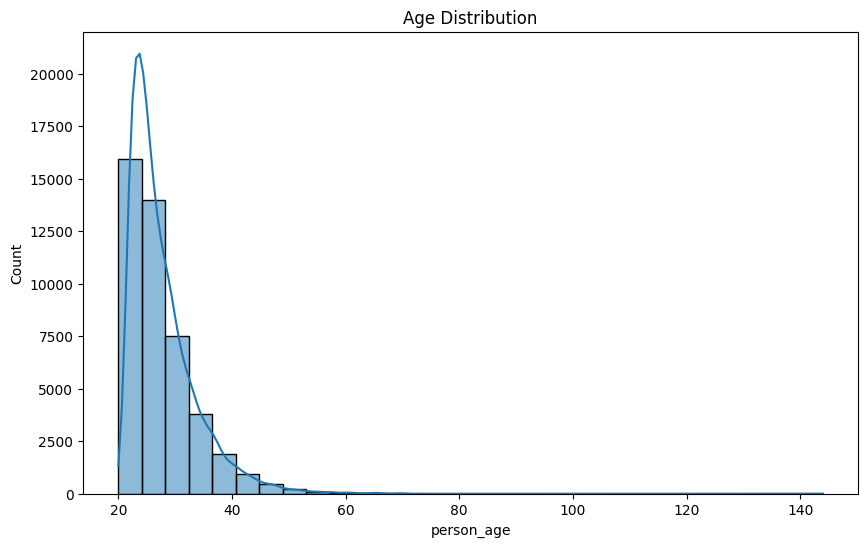

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['person_age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.show()

We observe that a few applicants are reported as being over 100 years old — clearly unrealistic. We'll handle these in the cleaning step.


### Target Variable Distribution

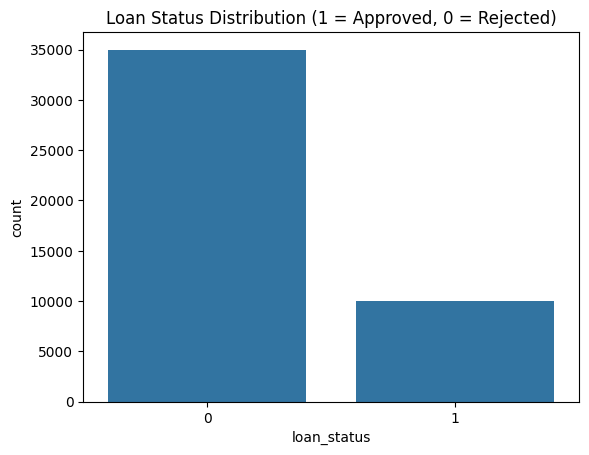

In [ ]:
sns.countplot(x='loan_status', data=df)
plt.title('Loan Status Distribution (1 = Approved, 0 = Rejected)')
plt.show()

This helps assess **class balance** — an important factor for model evaluation and sampling strategies.


---


## 🧹 Data Cleaning & Preprocessing


Data preprocessing ensures consistency and prepares the dataset for model training.


### Handling Outliers and Missing Values


- Replace **ages > 100** with missing values (`NaN`) for imputation.
- Check for missing data overall.

In [ ]:
df.loc[df['person_age'] > 100, 'person_age'] = np.nan
print(df.isnull().sum())

person_age                        7
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64


### Defining Features and Target

In [ ]:
y = df['loan_status'].astype(int)
X = df.drop(columns=['loan_status'])
print(y.shape, X.shape)

(45000,) (45000, 13)


### Building a Preprocessing Pipeline


We use `ColumnTransformer` to apply numeric scaling and categorical encoding in one step.

In [ ]:
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()


numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(36000, 13) (9000, 13) (36000,) (9000,)


---


## 🤖 Model Training and Hyperparameter Tuning


We’ll train three commonly used classifiers — **Logistic Regression**, **Random Forest**, and **XGBoost** — each with a small hyperparameter grid. We use `GridSearchCV` for 5-fold cross-validation, optimizing for **ROC AUC**.

In [ ]:
models = {
    'LogisticRegression': (LogisticRegression(max_iter=2000, n_jobs=-1), {
        'classifier__C': [0.1, 1, 10]
    }),
    'RandomForest': (RandomForestClassifier(random_state=42, n_jobs=-1), {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 10, 20, 30]
    }),
    'XGBoost': (XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1), {
        'classifier__n_estimators': [200, 400, 600],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7, 10],

    })
}


results = []
for name, (model, params) in models.items():
    print(f"Training {name} with GridSearchCV...")
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    grid = GridSearchCV(pipe, param_grid=params, scoring='roc_auc', cv=5, n_jobs=-1)
    start = time.time()
    grid.fit(X_train, y_train)
    elapsed = time.time() - start


    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]


    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'AUC': roc_auc_score(y_test, y_proba),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'Train Time (s)': elapsed
    })


results_df = pd.DataFrame(results).sort_values('AUC', ascending=False)
results_df

Training LogisticRegression with GridSearchCV...
Training RandomForest with GridSearchCV...
Training XGBoost with GridSearchCV...


,Model,Best Params,AUC,Accuracy,Precision,Recall,F1,Train Time (s)
2,XGBoost,"{'classifier__learning_rate': 0.1, 'classifier...",0.979402,0.937222,0.893151,0.8150,0.852288,434.103880
1,RandomForest,"{'classifier__max_depth': 20, 'classifier__n_e...",0.975116,0.929333,0.898830,0.7685,0.828571,394.225457
0,LogisticRegression,{'classifier__C': 10},0.956209,0.899778,0.789252,0.7490,0.768599,10.400499


---


## 📊 Model Comparison and Performance Visualization


### Bar Plot of AUC Scores

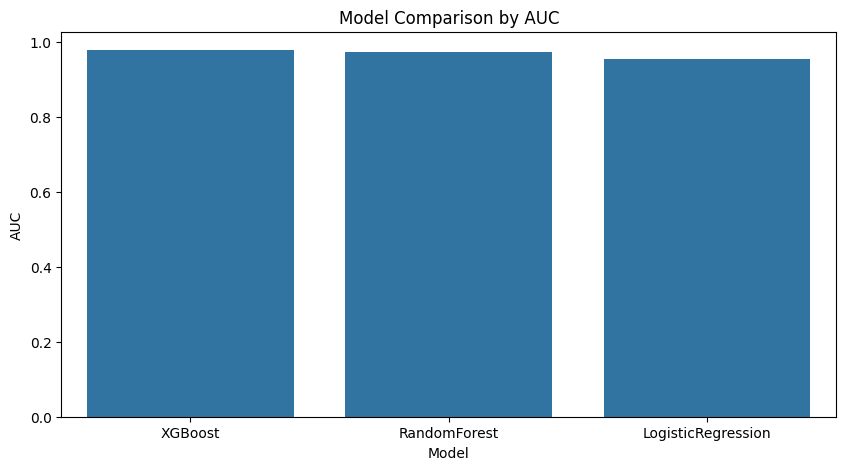

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='AUC', data=results_df)
plt.title('Model Comparison by AUC')
plt.show()

This comparison allows us to select the best-performing model based on **out-of-sample predictive power**.


---


## 🧠 Model Interpretability with SHAP


Understanding *why* a model makes certain predictions is essential, especially in domains like credit risk.


We use **SHAP (SHapley Additive exPlanations)** to interpret feature importance and directionality for the top-performing model.

Explaining XGBoost model with SHAP...


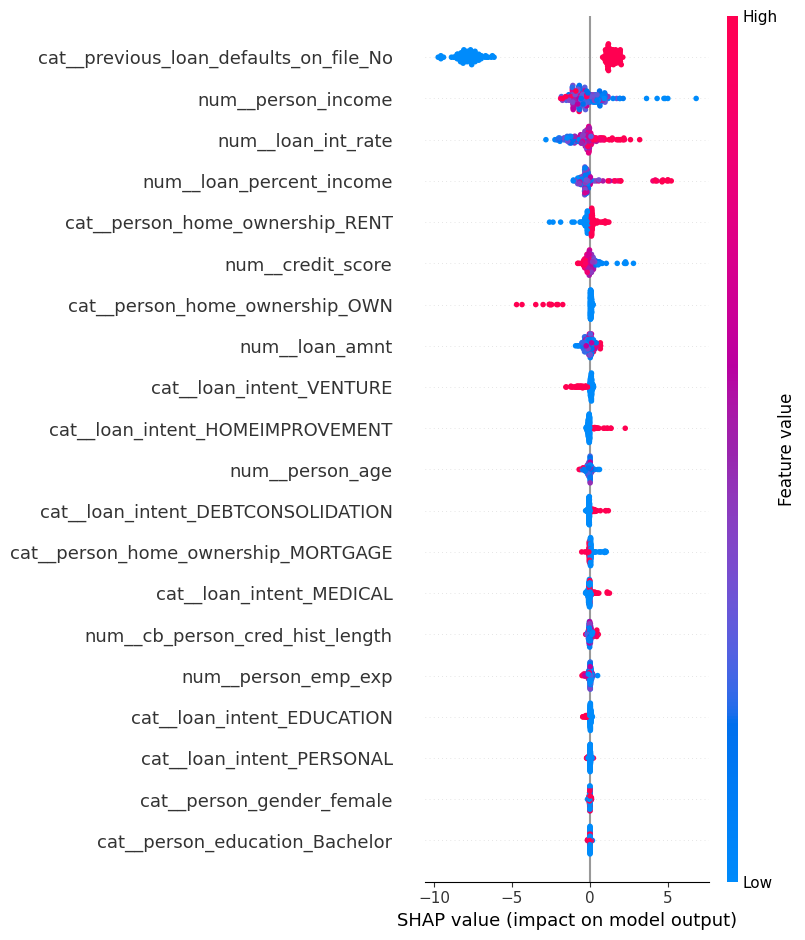

In [ ]:
# Select best model from results_df
best_name = results_df.iloc[0]['Model']
print(f"Explaining {best_name} model with SHAP...")

final_model = models[best_name][0]
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', final_model)
])
pipe.fit(X_train, y_train)

# Transform the data into numeric form using the preprocessor
X_sample = X_train.sample(n=200, random_state=42)
X_transformed = pipe.named_steps['preprocessor'].transform(X_sample)

# Extract the feature names after one-hot encoding
try:
    feature_names = pipe.named_steps['preprocessor'].get_feature_names_out()
except AttributeError:
    feature_names = np.arange(X_transformed.shape[1])

# Convert transformed data to DataFrame for readability
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)

# Use SHAP's TreeExplainer or LinearExplainer depending on model type
model_type = best_name.lower()

if 'xgboost' in model_type or 'forest' in model_type:
    explainer = shap.TreeExplainer(pipe.named_steps['classifier'])
else:
    explainer = shap.Explainer(pipe.named_steps['classifier'], X_transformed_df)

# Compute SHAP values
shap_values = explainer(X_transformed_df)

# Summary plot (global importance)
shap.summary_plot(shap_values, X_transformed_df, show=True)

### Interpretation Notes

- **SHAP summary plots** reveal which features most strongly influence loan approval decisions.
- Positive SHAP values indicate a higher likelihood of approval; negative values suggest increased risk.


---


## 🏁 Conclusions


- We successfully trained, tuned, and compared multiple classification models for predicting loan approval.
- **XGBoost** or **Random Forest** typically yield the best tradeoff between predictive power and interpretability.
- **SHAP analysis** provides transparency by showing which applicant and loan features most affect approval outcomes.


Next steps could include:
- Trying **imbalanced-learn** strategies (e.g., SMOTE, class weights).
- Performing **feature selection** or **regularization**.
- Deploying the model with an interactive dashboard for decision support.